In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from floris.tools import FlorisInterface

from flasc.model_tuning.floris_tuner import FlorisTuner

# Suppress warnings
import warnings


from floris import tools as wfct

from flasc.visualization import plot_layout_with_waking_directions

warnings.filterwarnings('ignore')

In [2]:
# Load the FLORIS models for GCH and EMG
file_path = Path.cwd()

fi_path = file_path / "../floris_input_artificial/gch.yaml"
fi_gch = wfct.floris_interface.FlorisInterface(fi_path)

fi_path = file_path / "../floris_input_artificial/emgauss.yaml"
fi_emg = wfct.floris_interface.FlorisInterface(fi_path)

<Axes: xlabel='x coordinate (m)', ylabel='y coordinate (m)'>

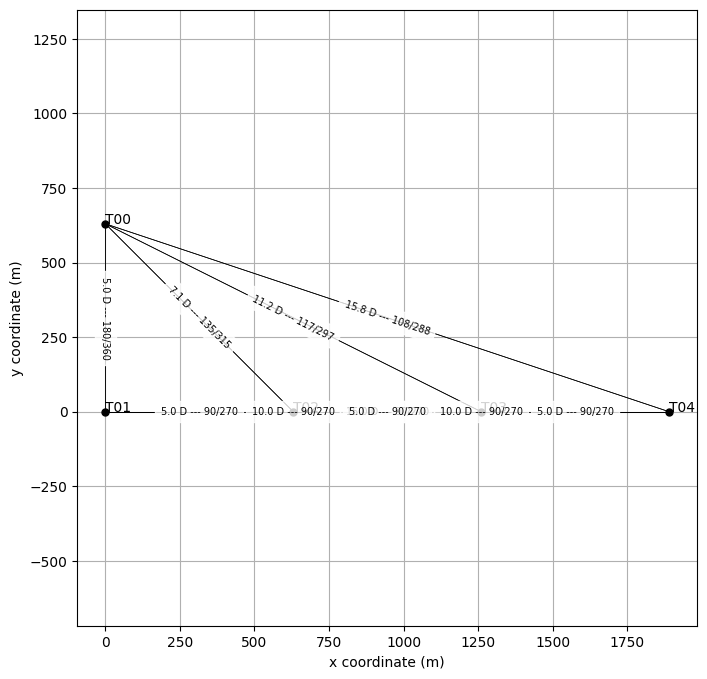

In [3]:
# Generate a data set using GCH
layout_x = [0, 0, 5*126, 10*126, 15*126]
layout_y = [5*126, 0, 0, 0, 0]
num_turbines = len(layout_x)
fi_gch.reinitialize(layout_x=layout_x, layout_y=layout_y)
fi_emg.reinitialize(layout_x=layout_x, layout_y=layout_y)

plot_layout_with_waking_directions(fi_gch)

Num Points 500


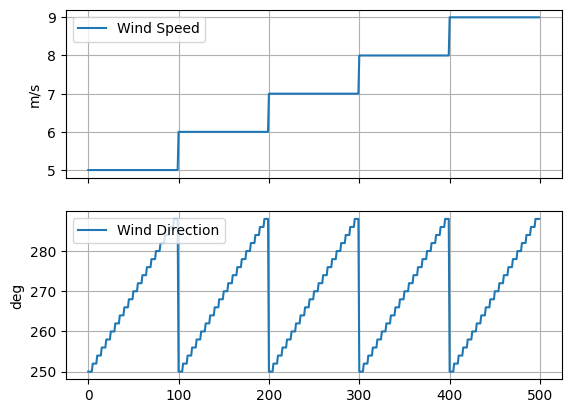

In [4]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,1.0)
wd_points = np.arange(250.0, 290.0, 2,)
num_points_per_combination = 5 # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

In [5]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi_gch.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi_gch.calculate_wake()
power_baseline_ref = fi_gch.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_baseline_control = fi_gch.get_turbine_powers().squeeze()[:,1].flatten() / 1000.
power_baseline_downstream_1 = fi_gch.get_turbine_powers().squeeze()[:,2].flatten() / 1000.
power_baseline_downstream_2 = fi_gch.get_turbine_powers().squeeze()[:,3].flatten() / 1000.
power_baseline_downstream_3 = fi_gch.get_turbine_powers().squeeze()[:,4].flatten() / 1000.

yaw_angles = np.zeros([len(ws_array),1,num_turbines]) * 25
yaw_angles[:,:,1] = 25 # Set control turbine yaw angles to 25 deg
fi_gch.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering_ref = fi_gch.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_wakesteering_control = fi_gch.get_turbine_powers().squeeze()[:,1].flatten() /1000.
power_wakesteering_downstream_1 = fi_gch.get_turbine_powers().squeeze()[:,2].flatten() /1000.
power_wakesteering_downstream_2 = fi_gch.get_turbine_powers().squeeze()[:,3].flatten() /1000.
power_wakesteering_downstream_3 = fi_gch.get_turbine_powers().squeeze()[:,4].flatten() /1000.

In [6]:
# Save the yaw angles
yaw_angles_base = 0 * yaw_angles
yaw_angels_wakesteering = yaw_angles

In [7]:
## Assemble into dataframes

df_baseline = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream_1,
    'pow_003':power_baseline_downstream_2,
    'pow_004':power_baseline_downstream_3,
})

df_wakesteering = pd.DataFrame({
    'wd':wd_array ,
    'ws':ws_array,
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream_1,
    'pow_003':power_wakesteering_downstream_2,
    'pow_003':power_wakesteering_downstream_3,
})

df_baseline_noisy = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*2,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream_1,
    'pow_003':power_baseline_downstream_2,
    'pow_004':power_baseline_downstream_3,
})

df_wakesteering_noisy = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*2,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream_1,
    'pow_003':power_wakesteering_downstream_2,
    'pow_004':power_wakesteering_downstream_3,
})

In [8]:
# Check stats on wd noise
noise_error = df_baseline_noisy['wd'].values  - wd_array
print(np.max(noise_error))
print(np.min(noise_error))
print(np.median(np.abs(noise_error)))

6.267871480563315
-5.688717696073866
1.3858623034043944


## Tune Wake Expansion (First Index) to baseline data

In [9]:
# Instantiate a FLORIS model tuner object
floris_tuner_baseline = FlorisTuner(fi=fi_emg,
                                    df_scada=df_baseline,
                                    yaw_angles=yaw_angles_base) 

floris_tuner_baseline_noisy = FlorisTuner(fi=fi_emg,
                                    df_scada=df_baseline_noisy,
                                    yaw_angles=yaw_angles_base) 

In [10]:
wake_expansion_rates = np.linspace(start=0.005, 
                                   stop=0.05,
                                   num=20)

#### Tuning to non-noisy data

Parameter 1 of 20...
Parameter 2 of 20...
Parameter 3 of 20...
Parameter 4 of 20...
Parameter 5 of 20...
Parameter 6 of 20...
Parameter 7 of 20...
Parameter 8 of 20...
Parameter 9 of 20...
Parameter 10 of 20...
Parameter 11 of 20...
Parameter 12 of 20...
Parameter 13 of 20...
Parameter 14 of 20...
Parameter 15 of 20...
Parameter 16 of 20...
Parameter 17 of 20...
Parameter 18 of 20...
Parameter 19 of 20...
Parameter 20 of 20...
Computing Error


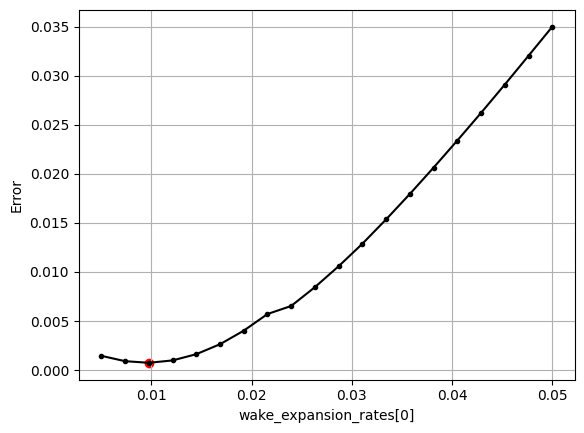

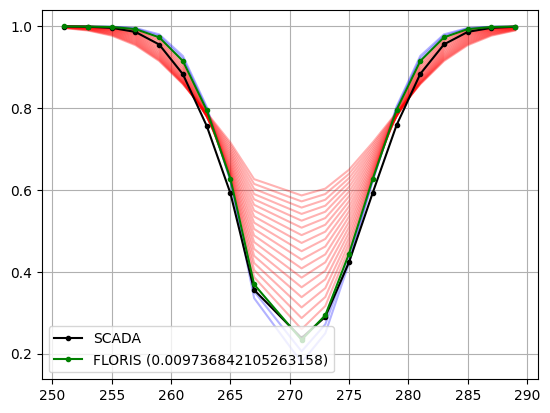

In [11]:
floris_tuner_baseline.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 0,
                                          test_turbines=[2],
                                          ref_turbines=[0],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline.calculate_param_errors()
floris_tuner_baseline.plot_error()
floris_tuner_baseline.plot_energy_ratios()



#### Tuning to noisy data

Parameter 1 of 20...
Parameter 2 of 20...
Parameter 3 of 20...
Parameter 4 of 20...
Parameter 5 of 20...
Parameter 6 of 20...
Parameter 7 of 20...
Parameter 8 of 20...
Parameter 9 of 20...
Parameter 10 of 20...
Parameter 11 of 20...
Parameter 12 of 20...
Parameter 13 of 20...
Parameter 14 of 20...
Parameter 15 of 20...
Parameter 16 of 20...
Parameter 17 of 20...
Parameter 18 of 20...
Parameter 19 of 20...
Parameter 20 of 20...
Computing Error


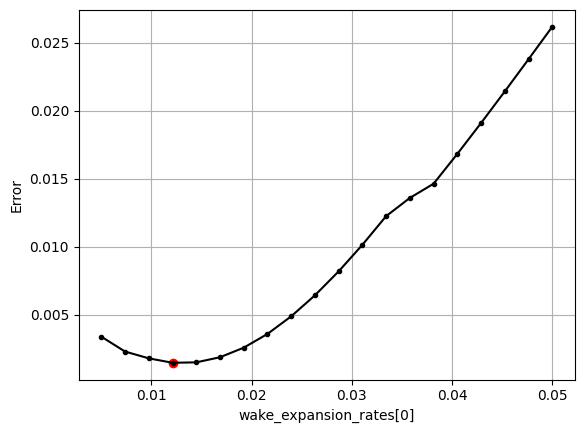

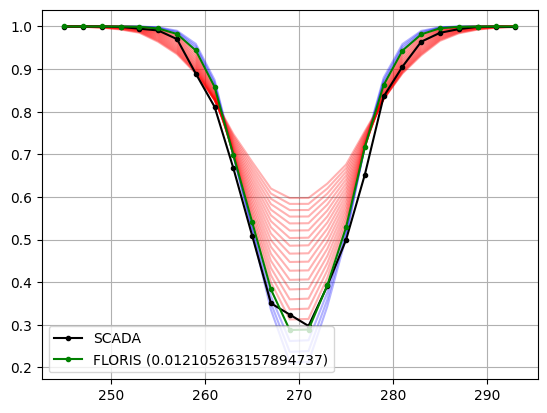

In [12]:
floris_tuner_baseline_noisy.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 0,
                                          test_turbines=[2],
                                          ref_turbines=[0],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline_noisy.calculate_param_errors()
floris_tuner_baseline_noisy.plot_error()
floris_tuner_baseline_noisy.plot_energy_ratios()

In [13]:
# Save the best FI parameters
fi_emg_2 = floris_tuner_baseline.apply_best_param()
fi_emg_2_noisy = floris_tuner_baseline_noisy.apply_best_param()


## Tune second index in recovery

In [14]:
# Instantiate a FLORIS model tuner object
floris_tuner_baseline = FlorisTuner(fi=fi_emg_2,
                                    df_scada=df_baseline,
                                    yaw_angles=yaw_angles_base) 

floris_tuner_baseline_noisy = FlorisTuner(fi=fi_emg_2_noisy,
                                    df_scada=df_baseline_noisy,
                                    yaw_angles=yaw_angles_base) 

Parameter 1 of 20...
Parameter 2 of 20...
Parameter 3 of 20...
Parameter 4 of 20...
Parameter 5 of 20...
Parameter 6 of 20...
Parameter 7 of 20...
Parameter 8 of 20...
Parameter 9 of 20...
Parameter 10 of 20...
Parameter 11 of 20...
Parameter 12 of 20...
Parameter 13 of 20...
Parameter 14 of 20...
Parameter 15 of 20...
Parameter 16 of 20...
Parameter 17 of 20...
Parameter 18 of 20...
Parameter 19 of 20...
Parameter 20 of 20...
Computing Error


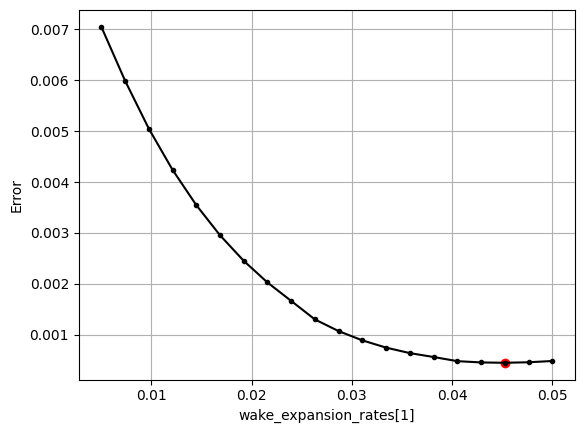

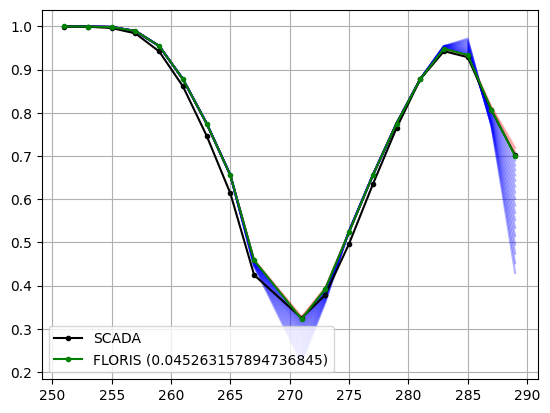

In [15]:
floris_tuner_baseline.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 1,
                                          test_turbines=[4],
                                          ref_turbines=[0],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline.calculate_param_errors()
floris_tuner_baseline.plot_error()
floris_tuner_baseline.plot_energy_ratios()

Parameter 1 of 20...
Parameter 2 of 20...
Parameter 3 of 20...
Parameter 4 of 20...
Parameter 5 of 20...
Parameter 6 of 20...
Parameter 7 of 20...
Parameter 8 of 20...
Parameter 9 of 20...
Parameter 10 of 20...
Parameter 11 of 20...
Parameter 12 of 20...
Parameter 13 of 20...
Parameter 14 of 20...
Parameter 15 of 20...
Parameter 16 of 20...
Parameter 17 of 20...
Parameter 18 of 20...
Parameter 19 of 20...
Parameter 20 of 20...
Computing Error


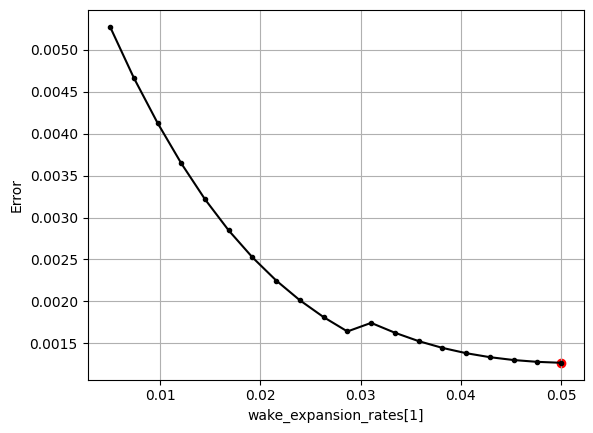

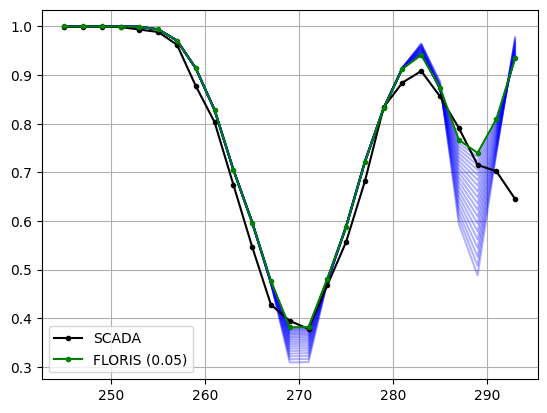

In [16]:
floris_tuner_baseline_noisy.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 1,
                                          test_turbines=[4],
                                          ref_turbines=[0],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline_noisy.calculate_param_errors()
floris_tuner_baseline_noisy.plot_error()
floris_tuner_baseline_noisy.plot_energy_ratios()

## Repeat on wake steering data

In [17]:
# Combine yaw angle matrices
yaw_total = np.concatenate([yaw_angles_base, yaw_angels_wakesteering], axis=0)

# Add the df_mode column
df_baseline['df_mode'] = 'baseline'
df_baseline_noisy['df_mode'] = 'baseline'
df_wakesteering['df_mode'] = 'wakesteering'
df_wakesteering_noisy['df_mode'] = 'wakesteering'

# Combine the dataframes
df_combined = pd.concat([df_baseline,df_wakesteering])
df_combined_noisy = pd.concat([df_baseline_noisy,df_wakesteering_noisy])


In [18]:
floris_tuner_wake_steering = FlorisTuner(fi=fi_emg_2,
                                    df_scada=df_combined,
                                    yaw_angles=yaw_total) 


floris_tuner_wake_steering_noisy = FlorisTuner(fi=fi_emg_2,
                                    df_scada=df_combined_noisy,
                                    yaw_angles=yaw_total) 

In [19]:
# Specify a range of wake expansion rates (assuming no breakpoints) values
horizontal_deflection_gains = np.linspace(start=0, 
                                   stop=4,
                                   num=10)

Parameter 1 of 10...
Parameter 2 of 10...
Parameter 3 of 10...
Parameter 4 of 10...
Parameter 5 of 10...
Parameter 6 of 10...
Parameter 7 of 10...
Parameter 8 of 10...
Parameter 9 of 10...
Parameter 10 of 10...
Computing Error


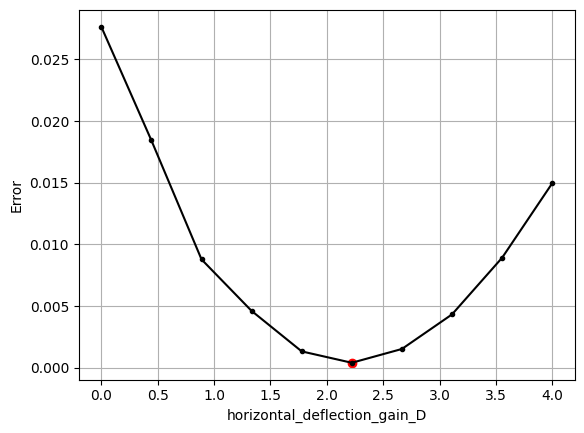

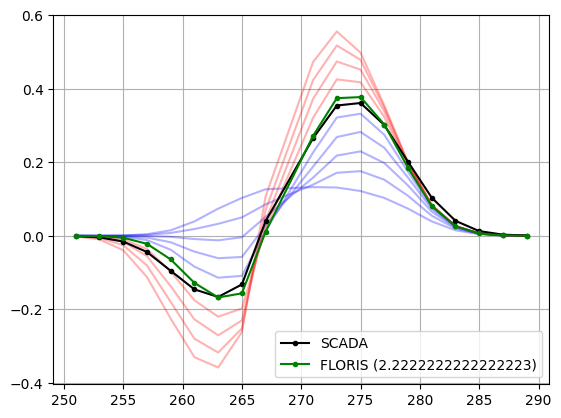

In [20]:
floris_tuner_wake_steering.evaluate_parameter_list(param=['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
                                          param_values=horizontal_deflection_gains,
                                          test_turbines=[2],
                                          ref_turbines=[0],
                                          use_predefined_ref=False,
                                          compare_uplift=True,
                                          df_mode_order = ['baseline','wakesteering']
                                          )


print('Computing Error')

floris_tuner_wake_steering.calculate_param_errors(compare_uplift=True)
floris_tuner_wake_steering.plot_error()
floris_tuner_wake_steering.plot_energy_ratio_uplifts()


Parameter 1 of 10...
Parameter 2 of 10...
Parameter 3 of 10...
Parameter 4 of 10...
Parameter 5 of 10...
Parameter 6 of 10...
Parameter 7 of 10...
Parameter 8 of 10...
Parameter 9 of 10...
Parameter 10 of 10...


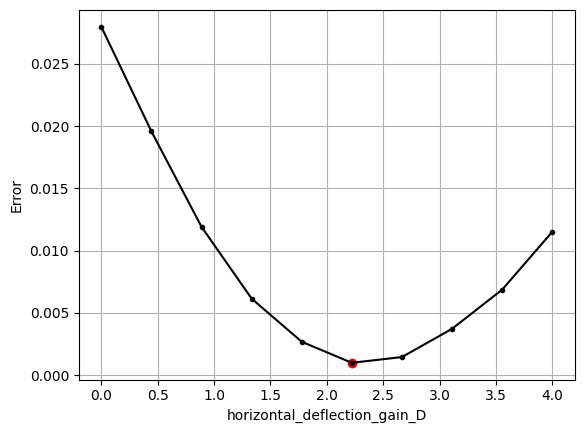

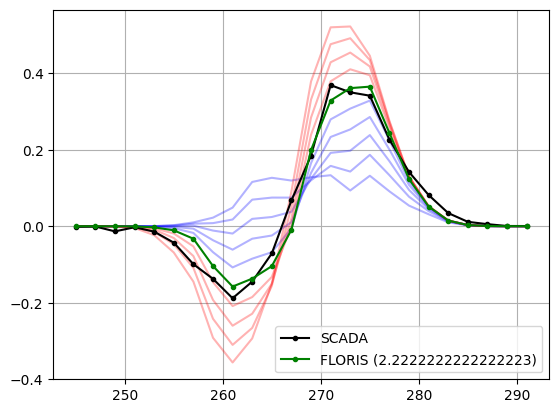

In [21]:
floris_tuner_wake_steering_noisy.evaluate_parameter_list(param=['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
                                          param_values=horizontal_deflection_gains,
                                          test_turbines=[2],
                                          ref_turbines=[0],
                                          use_predefined_ref=False,
                                          compare_uplift=True,
                                          df_mode_order = ['baseline','wakesteering']
                                          )


# print('Computing Error')

floris_tuner_wake_steering_noisy.calculate_param_errors(compare_uplift=True)
floris_tuner_wake_steering_noisy.plot_error()
floris_tuner_wake_steering_noisy.plot_energy_ratio_uplifts()
